# Phiên bản song song đầu tiên

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

path_final = "//content//drive//My Drive//LTSS//UD"
import os

if (os.path.isdir(path_final) == True):
  %cd "//content//drive//My Drive//LTSS//UD"

!ls

Mounted at /content/drive
/content/drive/My Drive/LTSS/UD
'parallel (1).ipynb'   parallelold.ipynb     'sequence (1).ipynb'
'parallel (2).ipynb'  'parallel (v0).ipynb'   winequality-red.csv


In [ ]:
import numpy as np
import pandas as pd
import sys
import math
import time
import matplotlib.pyplot as plt
from numba import cuda
import cProfile
#from numba import jit
from numba import cuda, float32, int32

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute  import SimpleImputer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
#np.set_printoptions(threshold=sys.maxsize)

**Những phần có khả năng song song hóa:**
- XGB tree
  - `find_best_split`: Tìm ra điểm dữ liệu tốt nhất để chia dữ liệu
  - `similarity`: Hàm tính giá trị similarity cho output và gain
- XGB Classifier
  - `residuals`: Tính giá trị sai lệch
  - `converter`: Chuyển probability sang dạng log(odds)

Ở phần trước khi chạy mô hình XGB tuần tự thì hàm `find_best_split` chiếm nhiều thời gian và số lần để chạy nhất. Nên nhóm sẽ tập trung song song hóa hàm này ở phiên bản song song này. Hàm này được chia ra làm 3 phần nhỏ và tất cả các phần đều song song được

## Các hàm được song song hóa:

In [ ]:

@cuda.jit
def mean_array(a, res): #Hàm tạo mảng tất cả các giá trị split_value của từng feature để tiến hành song song hóa
  r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  if(r < res.shape[0] and c < res.shape[1]):
    if(a[r, c] != a[r + 1, c]): #Chỉ lấy các giá trị khác nhau để tính mean còn lại sẽ trả về giá trị nan
      tmp = 0
      tmp = (a[r,c] + a[r+1,c])/2
      res[r,c] = tmp
    else:
      res[r,c] = np.nan

In [ ]:
ab = np.array([[1,3,2,2],[1,3,4,4],[1,34,45,56],[1,37,50,60],[2,39,61,61]])#Mảng giả lập được sort sẵn
a = np.sort(ab, axis=0)
res = np.empty((4,4))
mean_array[(1,1),(4,4)](a, res)
print(a)#Mảng ban đầu
print(res)#Mảng trả về

[[ 1  3  2  2]
 [ 1  3  4  4]
 [ 1 34 45 56]
 [ 1 37 50 60]
 [ 2 39 61 61]]
[[ nan  nan  3.   3. ]
 [ nan 18.5 24.5 30. ]
 [ nan 35.5 47.5 58. ]
 [ 1.5 38.  55.5 60.5]]


Lấy output của hàm trên làm input của hàm dưới đây:

In [ ]:
@cuda.jit
def cal_gain(split_val, X, y, p, min_impurity, res): #Hàm này trả về một mảng có kích thước bằng với mảng split_val nhưng mỗi giá trị split trong nó sẽ là giá trị gain tương ứng.
  r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  if(r < split_val.shape[0] and c < split_val.shape[1]):
    if(split_val[r, c] != np.nan): #skip các giá trị nan
      l_numerator = 0 #Phần tử số là gradient (tổng các residuals ở đây là y) 'l' là bên trái còn 'r' là bên phải giá trị split
      r_numerator = 0
      l_denominator = 0 #Phần tử số là hessian (tổng p*(1-p), với p là probability) 'l' là bên trái còn 'r' là bên phải giá trị split
      r_denominator = 0
      for i in range(X.shape[0]):
        if(X[i,c] <= split_val[r,c]):
          l_numerator = l_numerator + y[i]
          l_denominator = l_denominator + p[i]*(1 - p[i])
        else:
          r_numerator = r_numerator + y[i]
          r_denominator = r_denominator + p[i]*(1 - p[i])
      l_sim = (l_numerator**2)/(l_denominator + min_impurity)
      r_sim = (r_numerator**2)/(r_denominator + min_impurity)
      gain = l_sim + r_sim #giá trị gain được tính bằng công thức [gain = left_similarity + right_similarity - root_similarity]. root_similarity được cộng bên ngoài
      res[r,c] = gain
    else:
      res[r,c] = np.nan

In [ ]:
# tính độ chênh lệch
@cuda.jit
def residuals_kernel(y_true, y_pred, result):
    i = cuda.grid(1)
    if i < y_true.shape[0]:
        result[i] = y_true[i] - y_pred[i]

# chuyển đổi giá trị nhận từ hàm residuals_kernel
@cuda.jit
def converter_kernel(p, result):
    i = cuda.grid(1)
    if i < len(p):
      result[i] = math.log(p[i]/(1-p[i]))

# tính tổng của 1 mảng dùng hàm atomic (hoặc có thể sử dụng phương thức giống với hàm tìm vị trí max bên dưới)
@cuda.jit
def parallel_sum(array, result):
    i = cuda.grid(1)
    if i < array.shape[0]:
        cuda.atomic.add(result, 0, array[i])

# chuẩn hóa lại mảng residual
@cuda.jit
def denominator_similarity(p, result):
    i = cuda.grid(1)
    if i < p.shape[0]:
        result[i] = p[i] * (1 - p[i])

# xoay mảng và lưu vị trí cũ của các điểm
@cuda.jit
def rot_gain(p, result, row, col):
    r, c = cuda.grid(2)
    if r < p.shape[0] and c < p.shape[1]:
        result[c * p.shape[0] + r] = p[r, c]
        row[c * p.shape[0] + r] = r
        col[c * p.shape[0] + r] = c

# tìm vị trí lớn nhất
@cuda.jit
def find_max_position(in_array, out_array, n, airow, aicol):
    sa = cuda.shared.array(shape=(64), dtype=float32)
    i = (cuda.blockIdx.x * cuda.blockDim.x * 2) + (cuda.threadIdx.x * 2)

    if i < n:
      sa[i] = in_array[i]
      sa[i + 1] = in_array[i + 1]
    cuda.syncthreads()

    # reduce
    stride = 1
    while (stride < (2 * cuda.blockDim.x)):
      if (cuda.threadIdx.x % stride) == 0:
        if (i + stride) < n:
          if sa[i] < sa[i + stride]:
            sa[i] = sa[i + stride]
            airow[i] = airow[i + stride]
            aicol[i] = aicol[i + stride]

      cuda.syncthreads()
      stride = stride * 2

    if cuda.threadIdx.x == 0:
      out_array[cuda.blockIdx.x] = sa[cuda.blockIdx.x * cuda.blockDim.x * 2]
      airow[cuda.blockIdx.x] = airow[cuda.blockIdx.x * cuda.blockDim.x * 2]
      aicol[cuda.blockIdx.x] = aicol[cuda.blockIdx.x * cuda.blockDim.x * 2]

# tính giá trị cuối cùng theo learning rate
@cuda.jit
def cal_t(lo, lr, data, result):
  i = cuda.grid(1)
  if i < lo.shape[0]:
      result[i] = lo[i] + (lr * data[i])

# kích hoạt giá trị cuối cùng
@cuda.jit
def cal_exp(t, result):
  i = cuda.grid(1)
  if i < t.shape[0]:
    result[i] = math.exp(t[i]) / (1 + math.exp(t[i]))

## Thuật toán XGBoost

In [ ]:
class XGBoostTree:
    def __init__(self, max_depth=6, min_samples_split=1, min_impurity=1e-7, gamma = 0, block_size = 32):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.gamma = gamma
        self.block_size = block_size
        self.tree = {}
        self.fbs_t = [0,0]

    #split_data chia dữ liệu ra làm đôi
    def split_data(self, X, feature_index, split_value):
        left_indices = X[:, feature_index] <= split_value
        right_indices = X[:, feature_index] > split_value
        return left_indices, right_indices

    #Tính tất cả giá trị similarity của mảng input
    def similarity(self, y_true, p, i = 2):
        # tính tổng cho tử số
        gridn = math.ceil(y_true.shape[0]/self.block_size)
        numerator = np.zeros(1, dtype=y_true.dtype)
        parallel_sum[gridn, self.block_size](y_true, numerator)

        # tính similiraty cho đoạn prob
        gridd = math.ceil(p.shape[0]/self.block_size)
        denominator = np.zeros(p.shape, dtype=p.dtype)
        denominator_similarity[gridd, self.block_size](p, denominator)

        # tính tổng prob để làm mẫu số
        final_denom = np.zeros(1, dtype=denominator.dtype)
        parallel_sum[gridd, self.block_size](denominator, final_denom)

        return (numerator[0] ** i) / (final_denom[0] + self.min_impurity)

    # đổi mảng 2 chiều thành 1 chiều theo thứ tự ưu tiên (xoay mảng 90 độ theo chiều kim đồng hồ và lật mảng đó 180 độ sau đó về 1 chiều)
    def convert2d_2_1d(self, array_2d):
      rows, cols = array_2d.shape
      blocks_per_grid = ((rows + self.block_size - 1) // self.block_size, (cols + self.block_size - 1) // self.block_size)

      # lưu thêm vị trí dòng và cột của các phần từ sau khi chuyển đổi
      array_out = np.zeros((cols * rows), dtype=array_2d.dtype)
      airow = np.zeros((cols * rows), dtype=np.int64)
      aicol = np.zeros((cols * rows), dtype=np.int64)
      # Perform rotation and flip on GPU
      rot_gain[blocks_per_grid, (self.block_size, self.block_size)](array_2d, array_out, airow, aicol)

      return array_out, airow, aicol

    #Tìm giá trị split có gain cao nhất trong mảng input
    def find_best_split(self, X, y, probs):
        best_gain = -np.inf
        best_split_feature = None
        best_split_value = None

        num_samples, num_features = X.shape
        split_values = np.empty((X.shape[0]-1, X.shape[1])) #khởi tạo
        block_size = (self.block_size, self.block_size)
        grid1 = (math.ceil(split_values.shape[1]/block_size[0]),math.ceil(split_values.shape[0]/block_size[1]))
        mean_array[grid1, block_size](np.sort(X, axis=0).astype(np.float64), split_values)

        gains = np.empty((split_values.shape[0], split_values.shape[1])) #khởi tạo
        grid2 = (math.ceil(split_values.shape[1]/block_size[0]),math.ceil(split_values.shape[0]/block_size[1]))
        cal_gain[grid2, block_size](split_values, X, y, probs, self.min_impurity, gains)

        gains = gains - self.similarity(y, probs) #Trừ đi root similarity
        gains[np.isnan(gains)] = -np.inf #Gán nan bằng trừ vô cực để loại

        if(np.sum(gains == -np.inf) != gains.shape[0]*gains.shape[1]): #vì bên phần tuần tự giá trị lớn nhất sẽ ưu tiên từ bên trái trên cùng khác với hàm np.argmax()
          tid, airow, aicol = self.convert2d_2_1d(gains)
          # Tạo các biến lưu giá trị lớn nhất và vị trí tương ứng
          # Vì có giới hạn size bộ nhớ cuda ở colab nên phải tách ra từng đoạn với size n (ở đây 64) để tìm vị trí max
          tmp = [tid[i:i+(self.block_size * 2)] for i in range(0, len(tid), (self.block_size * 2))]
          srow = [airow[i:i+(self.block_size * 2)] for i in range(0, len(airow), (self.block_size * 2))]
          scol = [aicol[i:i+(self.block_size * 2)] for i in range(0, len(aicol), (self.block_size * 2))]
          max_v = -1
          max_r = -1
          max_c = -1
          flag = False

          for i in range(len(tmp)):
            max_val = np.zeros(tmp[i].shape[0], dtype=np.float64)
            threads_per_block = (self.block_size * 2)
            blocks_per_grid = ((tmp[i].shape[0] + threads_per_block - 1) // threads_per_block)

            find_max_position[blocks_per_grid, threads_per_block](tmp[i], max_val, tmp[i].shape[0], srow[i], scol[i])

            # lưu vị trí max tìm được từng đoạn và so sánh sau mỗi lượt để tìm max cuối cùng
            if flag == False:
              max_v = max_val[0]
              max_r = srow[i][0]
              max_c = scol[i][0]
              flag = True
            else:
              if max_v <= max_val[0]:
                max_v = max_val[0]
                max_r = srow[i][0]
                max_c = scol[i][0]

          midx = (int(max_r), int(max_c))

          best_split_feature = midx[1]
          best_gain = gains[midx]
          best_split_value = split_values[midx]

        if(best_gain - self.gamma < 0):
            best_split_feature = None
            best_split_value = None

        return best_split_feature, best_split_value

    #Tạo node lá
    def create_leaf_node(self, y, probs):
        return self.similarity(y, probs, 1)

    #Dựng cây
    def build_tree(self, X, y, probs, depth=0):
        if depth >= self.max_depth or len(X) <= self.min_samples_split:
            return self.create_leaf_node(y, probs)

        start = time.time()
        split_feature, split_value = self.find_best_split(X, y, probs)
        end = time.time()
        self.fbs_t[0] += 1
        self.fbs_t[1] += (end - start)

        if split_feature is None:
            return self.create_leaf_node(y, probs)

        left_indices, right_indices = self.split_data(X, split_feature, split_value)
        left_child = self.build_tree(X[left_indices], y[left_indices], probs[left_indices], depth + 1)
        right_child = self.build_tree(X[right_indices], y[right_indices], probs[right_indices], depth + 1)

        self.tree = {
            'split_feature': split_feature,
            'split_value': split_value,
            'left_child': left_child,
            'right_child': right_child
        }

        return self.tree

    def fit(self, X, y, probs):
        self.tree = self.build_tree(X, y, probs)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    #Truy suất cây được tạo để dự đoán giá trị
    def _traverse_tree(self, x, node):
        if isinstance(node, dict):
            split_feature = node['split_feature']
            split_value = node['split_value']
            if x[split_feature] <= split_value:
                return self._traverse_tree(x, node['left_child'])
            else:
                return self._traverse_tree(x, node['right_child'])
        else:
            return node

In [ ]:
#Loss function
def n_log_likelihood(y_true, y_pred):
    return -np.sum(y_true*np.log(y_pred)+ (1 - y_true)*np.log(1 - y_pred))

#Trả về đoạn [0,1] giống sigmoid (chỉ để thử nghiệm)
def softmax(z):
    return np.exp(z)/(np.sum(np.exp(z), axis = 0))

#Tạo cây
def build_weak_learner(X, y, probs, min_impurity, gamma, max_depth, block_size):
    # Create the weak learner (decision tree) and fit it to the gradients and Hessians
    model = XGBoostTree(min_impurity = min_impurity, gamma = gamma, block_size = block_size, max_depth=max_depth)  # Adjust the hyperparameters as needed
    model.fit(X, y, probs)  # Divide gradients by Hessians to account for second-order effects
    return model

# Define the XGBoost model
class XGBoostModel:
    def __init__(self, n_estimators, learning_rate, min_impurity = 1e-7, gamma = 0, debug = 0, max_depth = 6, block_size = 32):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.initial_prediction = 0
        self.min_impurity = min_impurity
        self.gamma = gamma
        self.debug = debug
        self.max_depth = max_depth
        self.block_size = block_size
        self.models = []
        self.fbs_t = [0,0] #các giá trị _t để đo thời gian
        self.con_t = [0,0]
        self.res_t = [0,0]
        self.ca_t = [0, 0]
        self.ca_exp = [0, 0]

    def fit(self, X, y):
        data = X
        classes, counts = np.unique(y, return_counts=True)
        #dominant_class = classes[np.argmax(counts)]
        self.initial_prediction = 0.5
        #self.initial_prediction = np.mean(y)
        predictions = np.full(len(y), self.initial_prediction, dtype =np.float64)
        # Build the models in a loop
        for _ in range(self.n_estimators):
            probs = np.copy(predictions)
            residual = np.empty_like(y, dtype=predictions.dtype)#np.empty(len(y))
            block_size = (32)
            grid = math.ceil(len(residual)/block_size)
            start = time.time()
            residuals_kernel[grid, block_size](y, predictions, residual)#Tính residual
            end = time.time()
            self.res_t[0] += 1
            self.res_t[1] += (end - start)
            #print(residual)

            # Fit a weak learner (e.g., a decision tree) to the gradients and Hessians
            model = build_weak_learner(data, residual, probs, self.min_impurity, self.gamma, self.max_depth, self.block_size)  # Implement your own weak learner
            self.fbs_t[0] += model.fbs_t[0]
            self.fbs_t[1] += model.fbs_t[1]

            # Update the predictions using the learning rate and the predictions of the weak learner
            log_odds = np.empty_like(y, dtype=np.float64)
            #block_size = (32)
            #grid = math.ceil(len(residual)/block_size)
            start = time.time()
            converter_kernel[grid, block_size](predictions, log_odds)#Tính log(odds)
            end = time.time()
            self.con_t[0] += 1
            self.con_t[1] += (end - start)

            # song song hóa các phép tính broadcoasting trên mảng tương tự tính tổng ở hàm similarity
            t = np.empty_like(log_odds, dtype=log_odds.dtype)
            start = time.time()
            cal_t[grid, block_size](log_odds, self.learning_rate, model.predict(data), t)
            end = time.time()
            self.ca_t[0] += 1
            self.ca_t[1] += (end - start)

            nt = np.empty_like(t, dtype=t.dtype)
            start = time.time()
            cal_exp[grid, block_size](t, nt)
            end = time.time()
            self.ca_exp[0] += 1
            self.ca_exp[1] += (end - start)

            predictions = np.around(nt, decimals = 14)#Làm tròn đến số thập phân thứ 14 để tránh tràn float64
            #print(predictions.dtype)
            if(self.debug == 1):
              print("n_log_likelihood: " + str(n_log_likelihood(y, predictions)))

            # Add the model to the ensemble
            self.models.append(model)

    def predict_proba(self, X):
        # Make predictions by aggregating the predictions of all models in the ensemble
        predictions = np.full(len(X),self.initial_prediction)
        for model in self.models:
            block_size = (32)
            grid = math.ceil(len(predictions)/block_size)
            log_odds = np.empty_like(predictions, dtype=np.float64)
            converter_kernel[grid, block_size](predictions, log_odds)
            t = np.empty_like(log_odds, dtype=log_odds.dtype)
            cal_t[grid, block_size](log_odds, self.learning_rate, model.predict(X), t)
            #t = np.log(predictions/(1-predictions)) + self.learning_rate * model.predict(X)
            nt = np.empty_like(t, dtype=t.dtype)
            cal_exp[grid, block_size](t, nt)
            predictions = np.around(nt, decimals = 14)
            #predictions = softmax(t)

        #predictions = predictions*(self.max - self.min) + self.min
        #print(predictions)
        return predictions

    def predict(self,X):
        return (self.predict_proba(X) > self.initial_prediction).astype(int)

## 1. Binary Classification

### 1. Wine dataset

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dat = pd.read_csv('winequality-red.csv')
dat['quality'] = pd.cut(dat['quality'], bins=[2, 5, 8], right=True, labels=False)+1
y = dat['quality']= le.fit_transform(dat['quality'])
X = dat.drop(['quality'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state = 5)
train_X.fillna(0, inplace = True)
test_X.fillna(0, inplace = True)
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [ ]:
train_y.shape

(1199,)

In [ ]:
print(train_X.shape)

(1199, 11)


In [ ]:
np.mean(train_y)

0.5396163469557965

In [ ]:
# Create and train the XGBoost model
xgb_model = XGBoostModel(n_estimators=500, learning_rate=0.3, min_impurity = 1, gamma = 0.2, max_depth = 5)
start = time.time()
xgb_model.fit(train_X, train_y)
end = time.time()
print("Total time: " + str(end-start))

Total time: 284.5304398536682


In [ ]:
# Make predictions
y_pred = xgb_model.predict(test_X)

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy_score : " + str(accuracy_score(test_y, y_pred)))

accuracy_score : 0.77


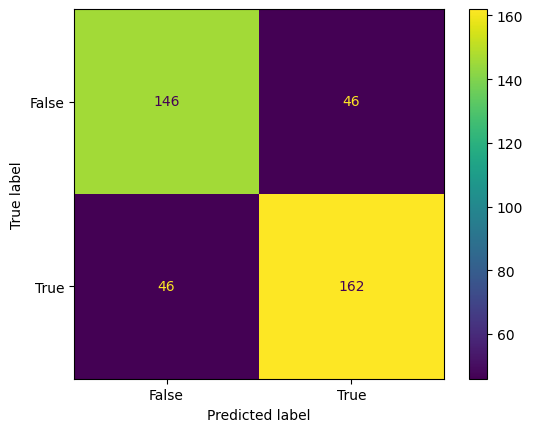

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test_y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
print("find_best_split total: " + str(xgb_model.fbs_t[0]) + ' in ' + str(xgb_model.fbs_t[1]) + 's')
print("residuals total: " + str(xgb_model.res_t[0]) + ' in ' + str(xgb_model.res_t[1]) + 's')
print("converter total: " + str(xgb_model.con_t[0]) + ' in ' + str(xgb_model.con_t[1]) + 's')
print("Esemble total: " + str(xgb_model.ca_t[0]) + ' in ' + str(xgb_model.ca_t[1]) + 's')
print("Sigmod total: " + str(xgb_model.ca_exp[0]) + ' in ' + str(xgb_model.ca_exp[1]) + 's')

find_best_split total: 1808 in 275.75285172462463s
residuals total: 500 in 0.7862987518310547s
converter total: 500 in 0.6064178943634033s
Esemble total: 500 in 1.2164826393127441s
Sigmod total: 500 in 0.598541259765625s
